## Use of VFA methods
The goal of this notebook is to show if it is possible to use VFA linear methods in the Slimevolley gym environment.

In [9]:
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gym
import slimevolleygym
from slimevolleygym import SurvivalRewardEnv
from algorithms import *

plt.style.use('seaborn')

# Define our input folders and output files
DATADIR = join('..', 'data')
LOGDIR = join('..', 'logs')

We create a wrapper which inherits from gym.ObservationWrapper to transform the 12-dimensional original observation space to a reduced 8-dimensional space. This way we eliminate the information from the opponent, which is not relevant for the agent operation.

In [10]:
class ReducedDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._observation_space = gym.spaces.Box(shape=(8,), low=-2.0, high=2.0)
    def observation(self, obs):
        return obs[0:8]

slime_env = SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0')))

We create the class BoundFeaturizer, which provides the definition of feature_vector. This allows to create a feature vector from a continuous observation space, given a number of partitions and a bound. We use radial base functions.

In [11]:
class BoundFeaturizer:
    def __init__(self, observation_space, partitions = 10, sigma = 0.1, bound = 5.0):
        self.n_dim = len(observation_space.low)
        self.sigma = sigma
        offset, scale_factor = [], []
        for i in range(self.n_dim):
            lower_bound = max(-1*bound, observation_space.low[i])
            upper_bound = min(bound, observation_space.high[i])
            offset.append(-1* lower_bound)
            scale_factor.append(1/(upper_bound - lower_bound))
        self.offset = np.array(offset, dtype=np.float_)
        self.scale_factor = np.array(scale_factor ,dtype=np.float_)
        scale = np.linspace(1.0/partitions,1.0,partitions) - 0.5/partitions
        self.landmarks = np.array(list(product(scale, repeat=self.n_dim)))
        self.n_parameters = partitions**self.n_dim
    
    def feature_vector(self, s):
        s = (s + self.offset) * self.scale_factor
        dist = (self.landmarks - s)**2
        f = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return f


In [12]:
featurizer = BoundFeaturizer(slime_env.observation_space, 3, sigma = 0.2, bound = 2.0)

##### Example: plot of feature vector from sampled states

In [6]:
ss_bsln = pd.read_csv(join(DATADIR, 'ss_bsln_900k.csv')).iloc[:, :8]
ss_random = pd.read_csv(join(DATADIR, 'ss_random_100k.csv')).iloc[:, :8]

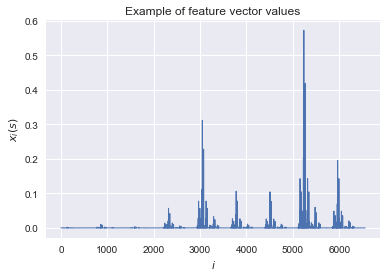

In [9]:
ss = pd.concat([ss_bsln, ss_random], ignore_index=True).sample(frac=1).to_numpy()
x = featurizer.feature_vector(ss[0, :])

fix, ax = plt.subplots()
ax.plot(x, linewidth=1)
ax.set_title('Example of feature vector values')
ax.set_ylabel('$x_i(s)$')
ax.set_xlabel('$i$');

In [15]:
def plot_results(rewards, lengths, title):
    rewards_avg = pd.DataFrame(rewards).expanding().mean()
    lengths_avg = pd.DataFrame(lengths).expanding().mean()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    ax1.set_title(title)

    ax1.plot(rewards, label='Reward per episode')
    ax1.plot(rewards_avg, label='Overall mean reward')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Reward')
    ax1.legend(loc='upper left')

    ax2.plot(lengths, label='Length per episode')
    ax2.plot(lengths_avg, label='Overall mean length')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Timesteps')
    ax2.legend(loc='upper left');
    

def save_results(rewards, lengths, file_name):
    training_data = np.vstack((rewards, lengths)).T
    np.savetxt(join(LOGDIR, file_name), training_data, delimiter=',',
               header='rewards,lengths', comments='')

### SARSA-LAMBDA

##### TEST 1: lambda = 0.99; alpha, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

In [47]:
save_results(slime_rewards, slime_lengths, 'test1.csv')

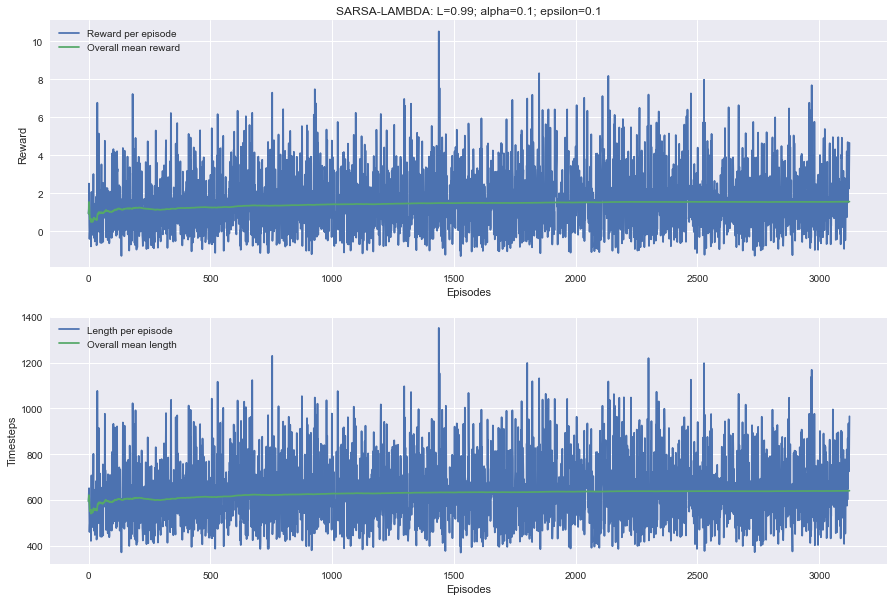

In [48]:
slime_info = pd.read_csv(join(LOGDIR, 'test1.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.1; epsilon=0.1")

##### TEST 2: lambda = 0.99; alpha, epsilon = 0.3

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

In [50]:
save_results(slime_rewards, slime_lengths, 'test2.csv')

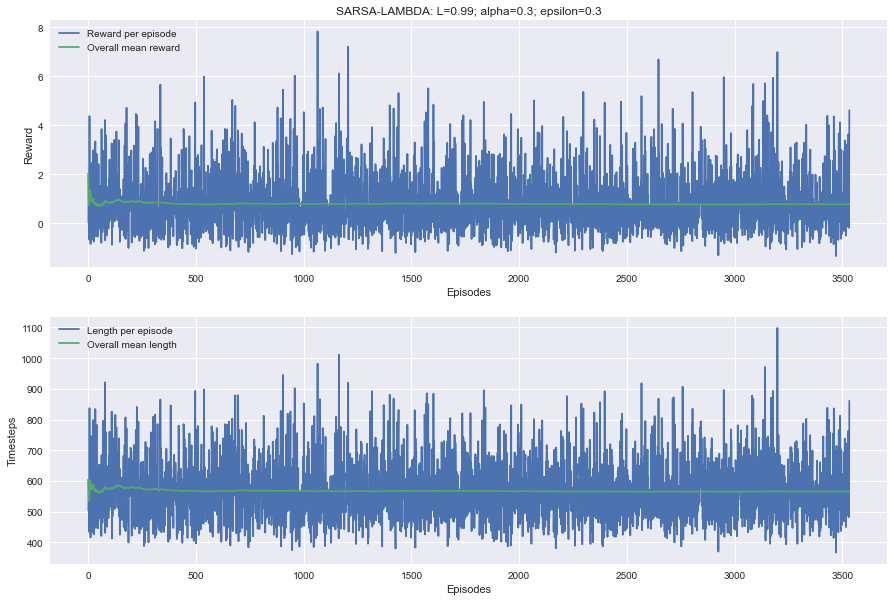

In [51]:
slime_info = pd.read_csv(join(LOGDIR, 'test2.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.3; epsilon=0.3")

##### TEST 3: lambda = 0.99; alpha, epsilon = 0.5

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

In [53]:
save_results(slime_rewards, slime_lengths, 'test3.csv')

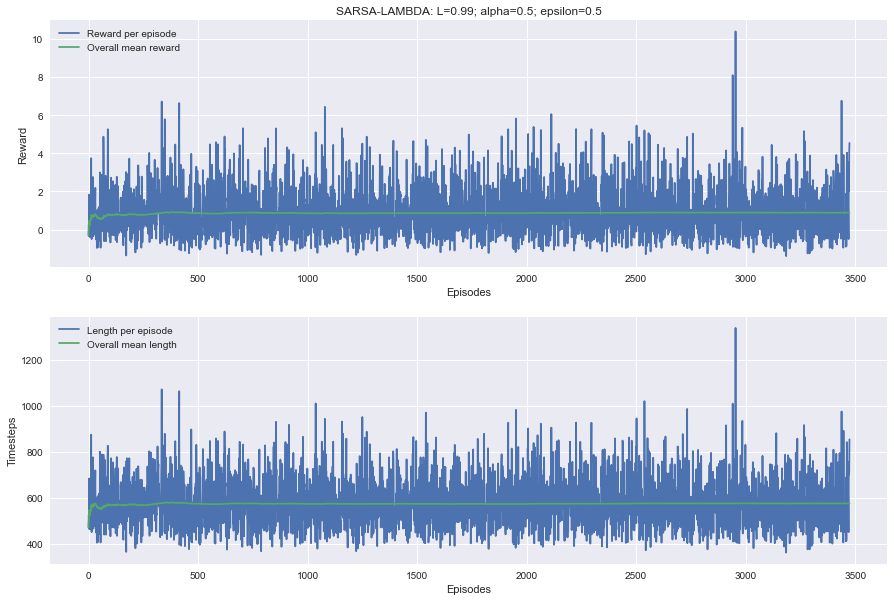

In [54]:
slime_info = pd.read_csv(join(LOGDIR, 'test3.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.99; alpha=0.5; epsilon=0.5")

##### TEST 4: lambda = 0.9; alpha, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

In [12]:
save_results(slime_rewards, slime_lengths, 'test4.csv')

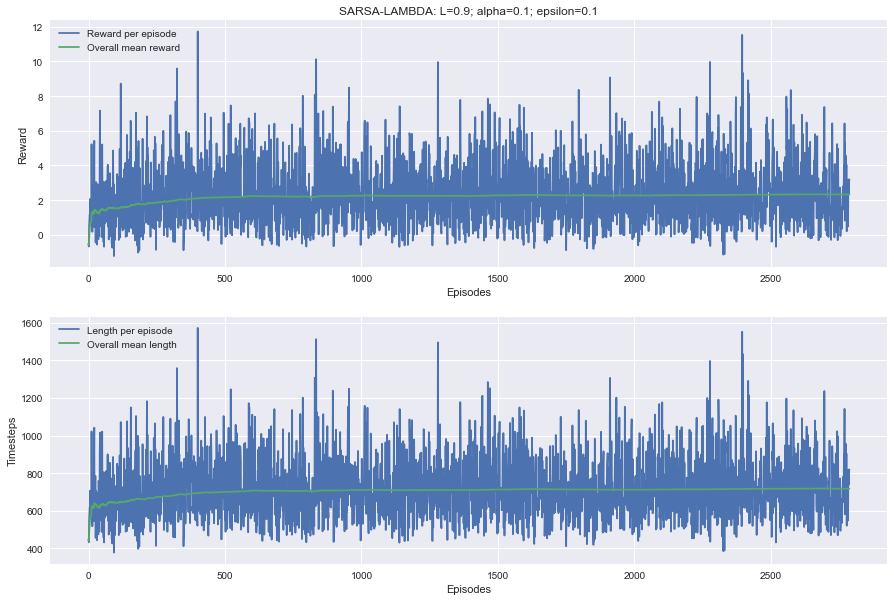

In [44]:
slime_info = pd.read_csv(join(LOGDIR, 'test4.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.1; epsilon=0.1")

##### TEST 5: lambda = 0.9; alpha, epsilon = 0.3

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

In [17]:
save_results(slime_rewards, slime_lengths, 'test5.csv')

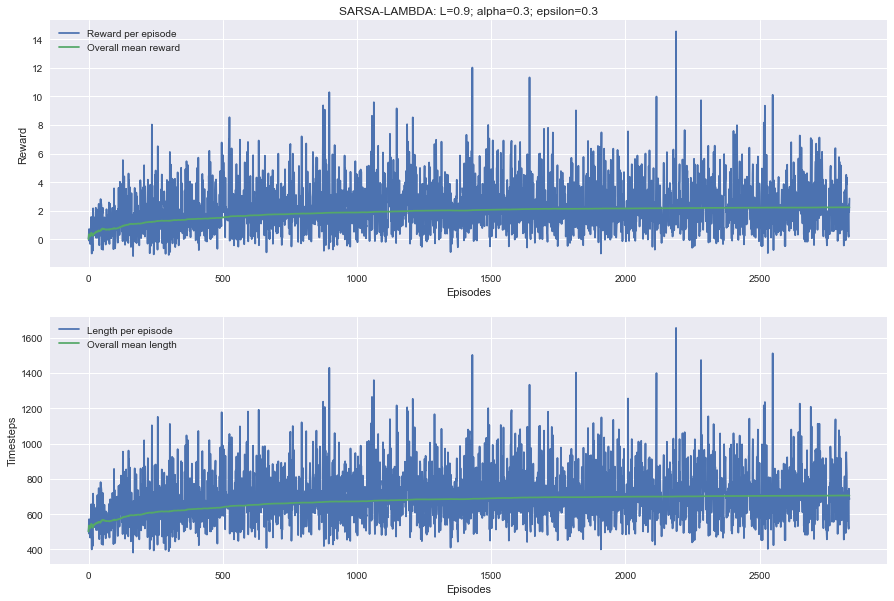

In [43]:
slime_info = pd.read_csv(join(LOGDIR, 'test5.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.3; epsilon=0.3")

##### TEST 6: lambda = 0.9; alpha, epsilon = 0.5

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

In [20]:
save_results(slime_rewards, slime_lengths, 'test6.csv')

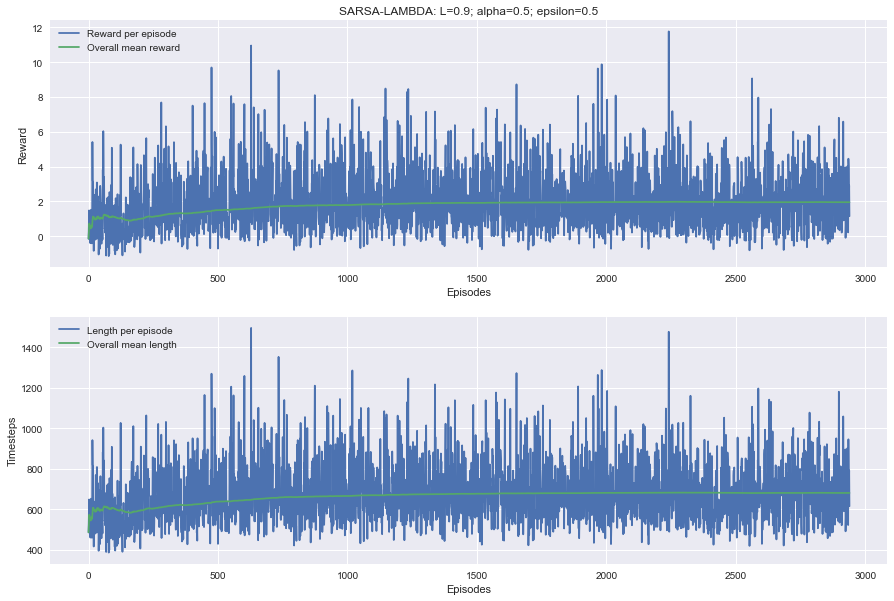

In [42]:
slime_info = pd.read_csv(join(LOGDIR, 'test6.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.5; epsilon=0.5")

##### TEST 7: lambda = 0.7; alpha, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

In [23]:
save_results(slime_rewards, slime_lengths, 'test7.csv')

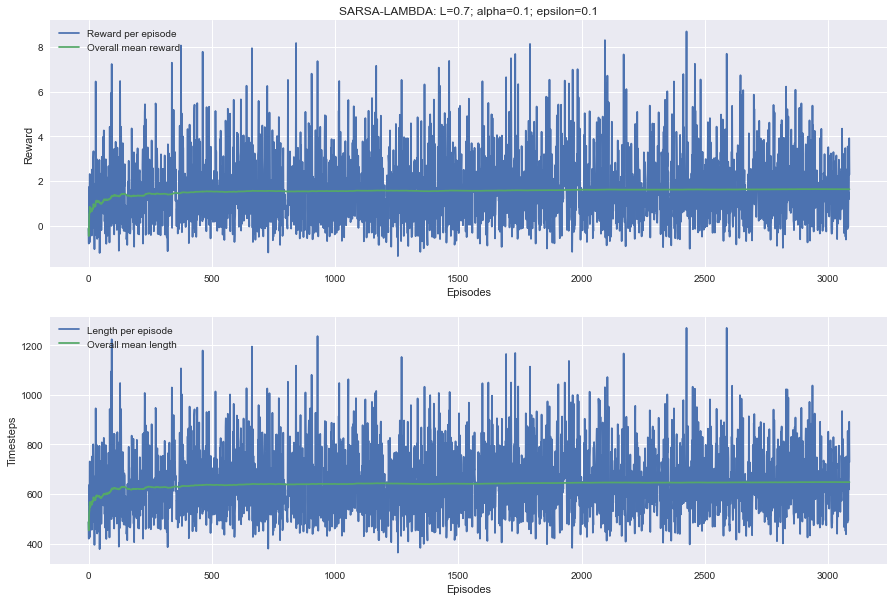

In [41]:
slime_info = pd.read_csv(join(LOGDIR, 'test7.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.1; epsilon=0.1")

##### TEST 8: lambda = 0.7; alpha, epsilon = 0.3

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.3, alpha=0.3)

In [26]:
save_results(slime_rewards, slime_lengths, 'test8.csv')

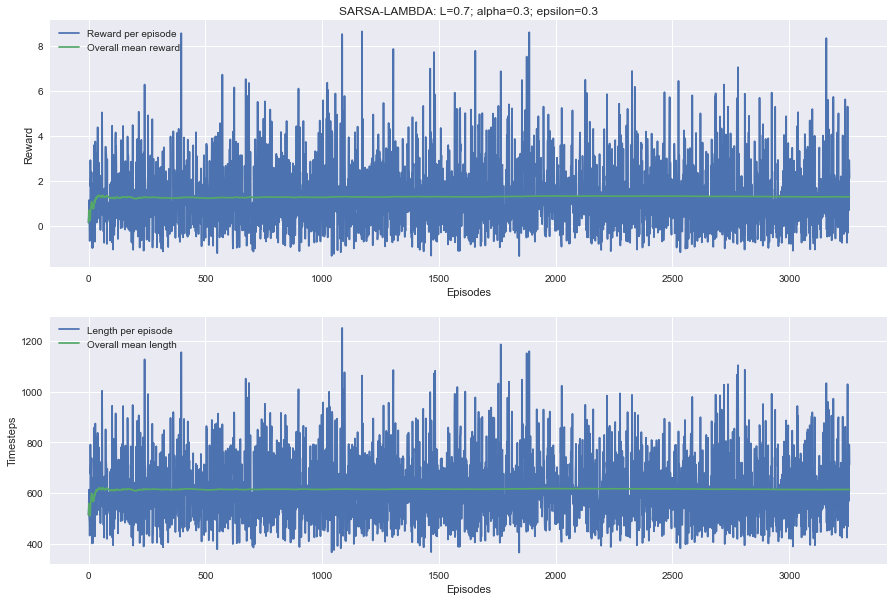

In [39]:
slime_info = pd.read_csv(join(LOGDIR, 'test8.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.3; epsilon=0.3")

##### TEST 9: lambda = 0.7; alpha, epsilon = 0.5

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.7)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.5, alpha=0.5)

In [29]:
save_results(slime_rewards, slime_lengths, 'test9.csv')

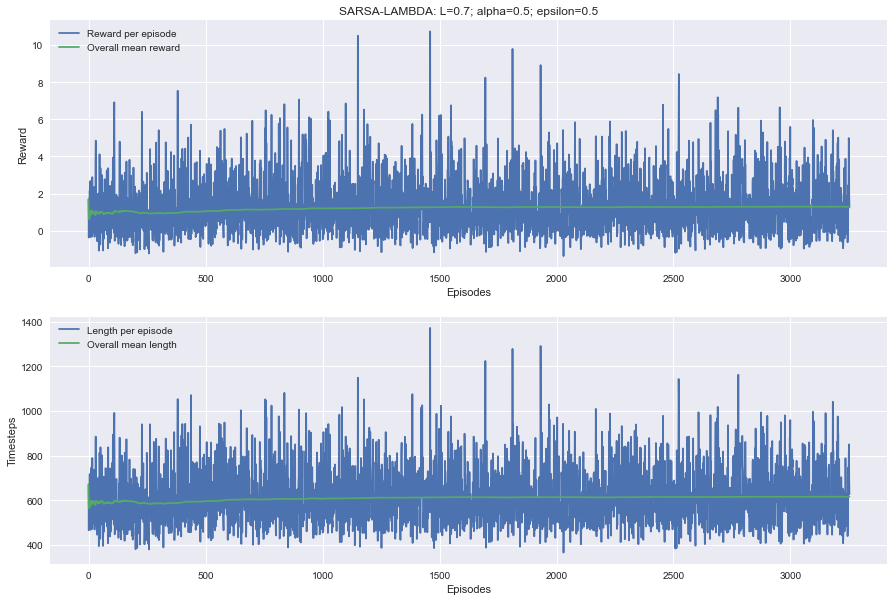

In [38]:
slime_info = pd.read_csv(join(LOGDIR, 'test9.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.7; alpha=0.5; epsilon=0.5")

##### TEST 10: lambda = 0.9; alpha = 0.03, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.03)

In [19]:
save_results(slime_rewards, slime_lengths, 'test10.csv')

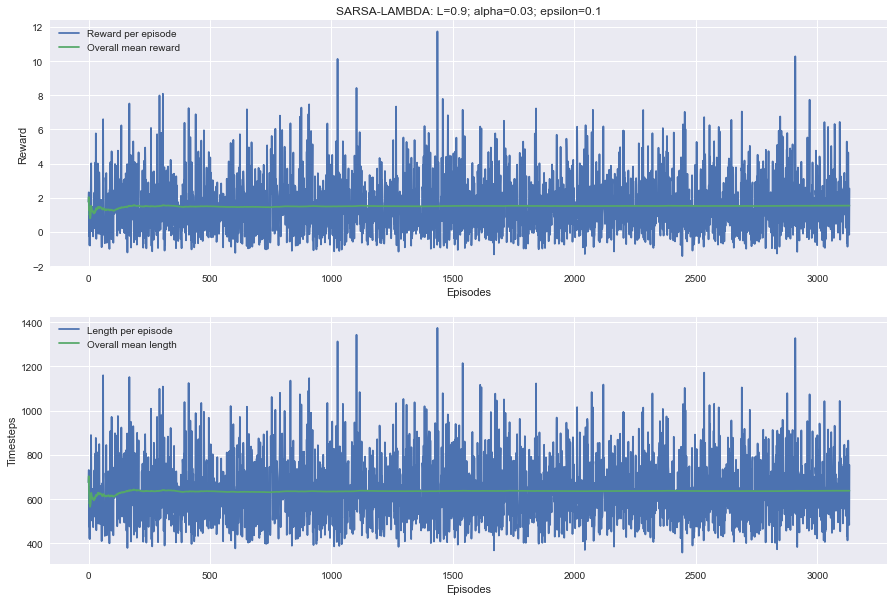

In [20]:
slime_info = pd.read_csv(join(LOGDIR, 'test10.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.03; epsilon=0.1")

##### TEST 11: lambda = 0.9; alpha = 0.01, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.9)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.01)

In [22]:
save_results(slime_rewards, slime_lengths, 'test11.csv')

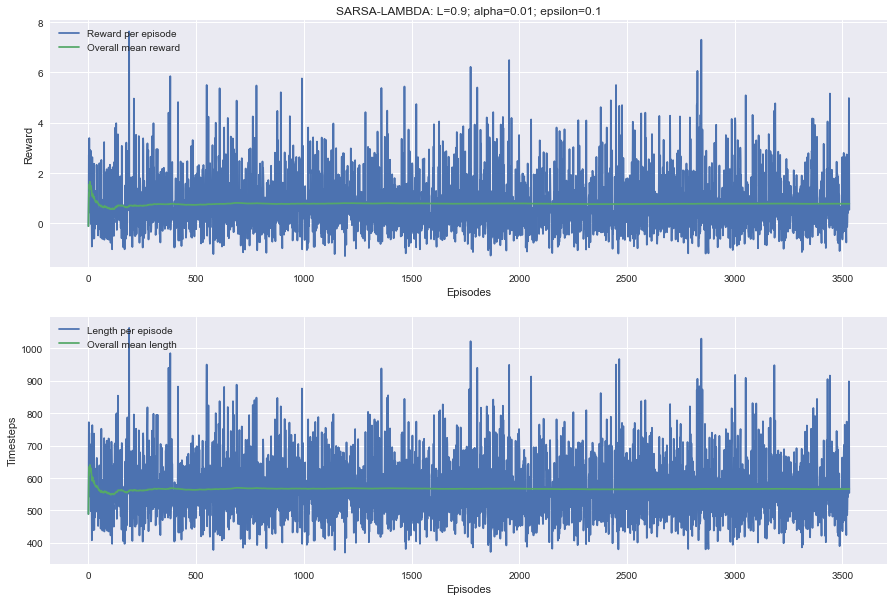

In [23]:
slime_info = pd.read_csv(join(LOGDIR, 'test11.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.9; alpha=0.01; epsilon=0.1")

##### TEST 12: lambda = 0.95; alpha = 0.1, epsilon = 0.1

In [ ]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.95)
slime_q, slime_rewards, slime_lengths = sarsa_lambda(slime_env, q, 2_000_000,
                                                    gamma=1, epsilon=0.1, alpha=0.1)

In [35]:
save_results(slime_rewards, slime_lengths, 'test12.csv')

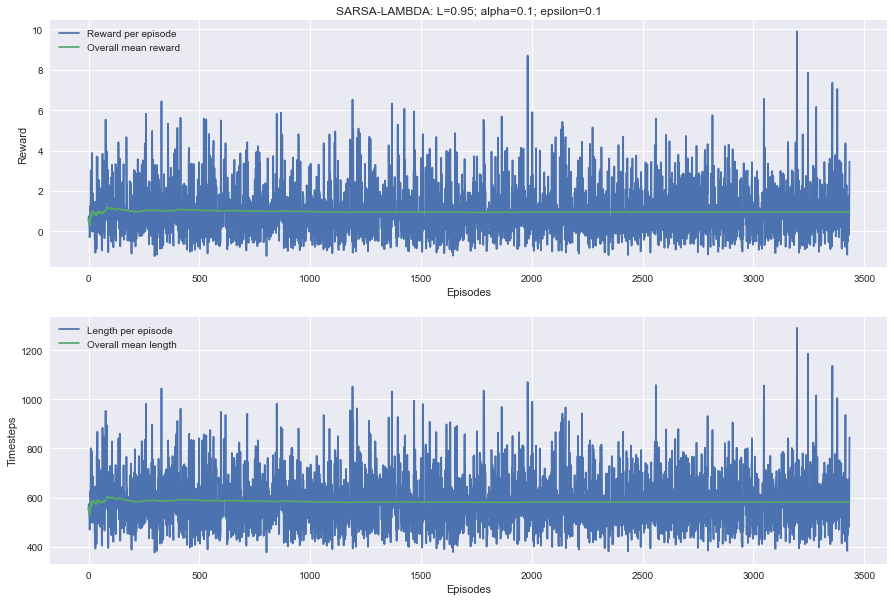

In [36]:
slime_info = pd.read_csv(join(LOGDIR, 'test12.csv'))
plot_results(slime_info.loc[:, 'rewards'], slime_info.loc[:, 'lengths'],
             "SARSA-LAMBDA: L=0.95; alpha=0.1; epsilon=0.1")

#### Results

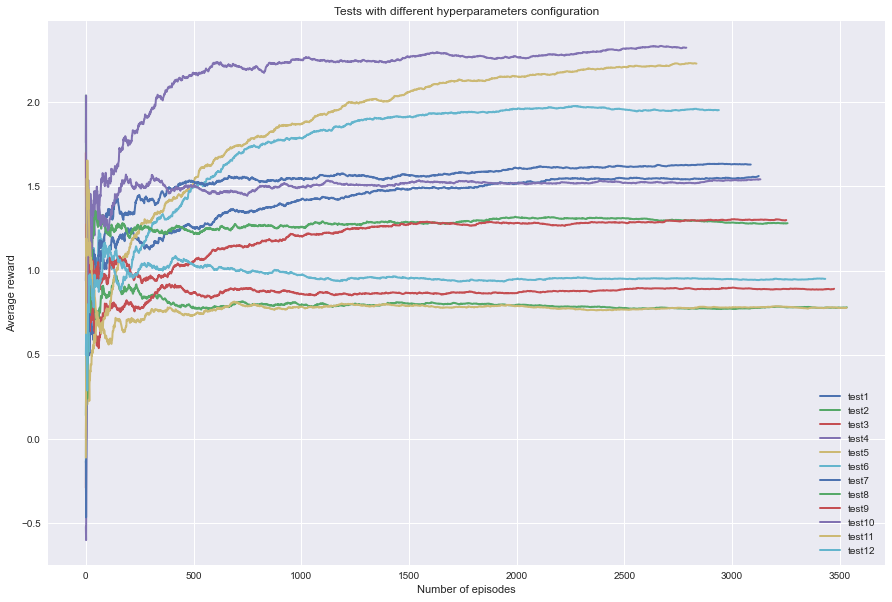

In [40]:
slime_avg_rews = pd.DataFrame({
    "test1": pd.read_csv(join(LOGDIR, 'classic', 'test1.csv')).loc[:, 'rewards'].expanding().mean(),
    "test2": pd.read_csv(join(LOGDIR, 'classic', 'test2.csv')).loc[:, 'rewards'].expanding().mean(),
    "test3": pd.read_csv(join(LOGDIR, 'classic', 'test3.csv')).loc[:, 'rewards'].expanding().mean(),
    "test4": pd.read_csv(join(LOGDIR, 'classic', 'test4.csv')).loc[:, 'rewards'].expanding().mean(),
    "test5": pd.read_csv(join(LOGDIR, 'classic', 'test5.csv')).loc[:, 'rewards'].expanding().mean(),
    "test6": pd.read_csv(join(LOGDIR, 'classic', 'test6.csv')).loc[:, 'rewards'].expanding().mean(),
    "test7": pd.read_csv(join(LOGDIR, 'classic', 'test7.csv')).loc[:, 'rewards'].expanding().mean(),
    "test8": pd.read_csv(join(LOGDIR, 'classic', 'test8.csv')).loc[:, 'rewards'].expanding().mean(),
    "test9": pd.read_csv(join(LOGDIR, 'classic', 'test9.csv')).loc[:, 'rewards'].expanding().mean(),
    "test10": pd.read_csv(join(LOGDIR, 'classic', 'test10.csv')).loc[:, 'rewards'].expanding().mean(),
    "test11": pd.read_csv(join(LOGDIR, 'classic', 'test11.csv')).loc[:, 'rewards'].expanding().mean(),
    "test12": pd.read_csv(join(LOGDIR, 'classic', 'test12.csv')).loc[:, 'rewards'].expanding().mean()
})

fig, ax = plt.subplots(figsize=(15, 10))

for i in range(slime_avg_rews.shape[1]):
    ax.plot(slime_avg_rews.iloc[:, i], linewidth=2, label='test'+str(i+1))
    
ax.legend(loc='lower right')
ax.set_title('Tests with different hyperparameters configuration')
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Average reward');

### ACTOR-CRITIC (LAMBDA)

##### TEST 13: lambda_actor/critic = X; alpha = X; beta = X

In [ ]:
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 2_000_000, \
                                                                alpha=0.001, beta=0.005, gamma = 0.99)

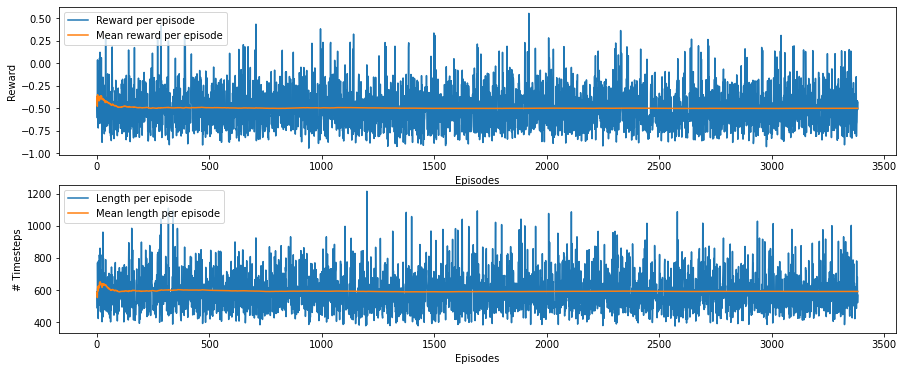

In [24]:
plot_vfa_results(slime_rewards, slime_lengths)